In [115]:
import pandas as pd
import numpy as np
from pathlib import Path

import src.features.build_features as feat

idx = pd.IndexSlice

# Feature engineering
To reiterate, the aggregate metrics I have to work with are inherited from data loggers outside my control. I would define different aggregates (or not even aggregate at all) if it were up to me. The following features are attempts to glean the most information out of the available metrics.

In [116]:
data_path = Path('../data/processed/cup_10_min_aggs.parquet')
assert data_path.exists()

In [117]:
met = pd.read_parquet(data_path)
met.head(1).T

timestamp                              2018-12-31 17:00:00
Air_Temp_87m   count                            600.000000
               max                              -15.477113
               mean                             -15.691004
               min                              -15.805410
               var                                0.002746
Cup_WS_C1_105m 3s_gust                            8.805074
               count                            600.000000
               integrated_low_freq_ke             0.212934
               max                                8.917205
               mean                               7.490526
               min                                5.818164
               var                                0.288631
Cup_WS_C1_130m 3s_gust                            8.685490
               count                            600.000000
               integrated_low_freq_ke             0.195348
               max                                9.123878
               mean                               7.629745
               min                                6.183786
               var                                0.257707
DeltaT_122_87m count                            600.000000
               max                               -0.274433
               mean                              -0.304441
               min                               -0.330359
               var                                0.000068
Vane_WD_122m   count                            600.000000
               max                               33.494219
               mean                              22.310701
               min                               11.305162
               var                               15.631823
Vane_WD_87m    count                            600.000000
               max                               36.993735
               mean                              23.033820
               min                               10.439399
               var                               17.199339

## Cyclic features
There are three cyclic features here: wind direction (angle), time of year (seasonal cycle), and time of day (diurnal cycle). In a cyclic feature, points at the beginning and end of the data ranges are actually adjacent: 0 degrees is close to 359 degreees, January is close to December, and 00:01 is close to 23:59. What would normally be simple linear operations, like feature1 - feature2, are non-linear with cyclic features. There are two ways to capture these relationships: 1) reimplement every model to use cyclic-aware arithmetic, or 2) convert the cyclic features to 2 component dimensions with sine and cosine transforms. Option 2 is the practical choice, and is what I'll do here.
### Time of Year
Of course the calendar itself is not causal - time of year is a proxy for the earth's axial tilt and associated seasonality effects.

Time of year may not add much predictive value for this use case because of the single year of data and blocked CV schema. This means large chunks of a season will be held out, forcing the model to extrapolate and hurting performance. But I think it is still a preferred outcome to the non-blocked alternative: overconfident CV due to data leakage from autocorrelation.
### Time of Day
Like time of year, time of day is a proxy variable for a separate causal mechanism: the rising and setting of the sun and its associated processes.

In [118]:
minute_of_day = met.index.hour * 60 + met.index.minute
minute_of_year = (met.index.dayofyear - 1) * 60 * 24 + minute_of_day # dayofyear starts at 1; shift -1 to zero-index
# scale to radians
minute_of_day *= 2 * np.pi / (24 * 60)
minute_of_year *= 2 * np.pi / (365 * 24 * 60) # data is from 2019 so I'll ignore leap years

In [119]:
# check. Maxes are different due to different resolutions
# 144 10 minute periods per day, 52560 10 min periods per year
minute_of_day.min(), minute_of_day.max(), minute_of_year.min(), minute_of_year.max()

(0.0, 6.239552075879728, 0.0, 6.283065764080135)

In [120]:
met.loc[:, ('derived', 'season_sin')] = np.sin(minute_of_year)
met.loc[:, ('derived', 'season_cos')] = np.cos(minute_of_year)
met.loc[:, ('derived', 'day_sin')] = np.sin(minute_of_day)
met.loc[:, ('derived', 'day_cos')] = np.cos(minute_of_day)

### Wind Direction
Wind direction is different from time of day/year for two reasons: 1) there are multiple aggregate metrics (mean, min, max) which are each cyclical, and 2) there are two sets of wind direction measurements, at different heights. The challenge is to represent them in a way that downstream models, which have no concept of cyclic operations, can make meaningful linear combinations or decision splits with. One option is to simply sin/cos transform all the features, but that leaves the models to figure everything out on their own. That condemns a linear model to irrelevance, and even nonlinear models probably need more data than I have to succeed with that approach. Instead, I'll use differencing to simultaneously better represent what what I actually care about AND reduce the importance of cyclic wrapping.

#### Cyclic aggregate stats
The purpose of mean, min, max, and var stats is to describe the distribution of wind directions. A direction distribution consists of two pieces of information: location, which is cyclical, and 'spread', which isn't. I'll put the location information into the mean, and do the appropriate sine/cosine transformations. But for min and max, I no longer need their location information and can replace them with (min - mean) and (max - mean). This isolates the 'spread' information, and removes the cyclic part. This is important because now comparisons can be done with linear operations, and I don't need to sin/cos transform them. I'll also express the differences as z-scores by dividing by direction standard deviation.

In [121]:
# keep track of redundant features
redundant_features = []
# convert min, max to z-normed spreads
for vane in ['Vane_WD_122m', 'Vane_WD_87m']:
    std_dev = np.sqrt(met.loc[:, (vane, 'var')].to_numpy())
    for stat in ['min', 'max']:
        met.loc[:, (vane, f'{stat}_z')] = feat.angular_difference(met.loc[:, (vane, stat)],
                                                                  met.loc[:, (vane, 'mean')]) / std_dev
        redundant_features.append((vane, stat))

#### Multiple heights
Redundant measurements are highly correlated. I'll express them additively, in terms of a reference direction and the difference between them (called veer). I'll leave the difference as a single dimension with range (-180, 180], simply because there will rarely be differences more than 90 degrees, so cyclic wrapping is less of a concern.

Finally, I could save a dimension and combine wind speed with sin/cos transforms of wind direction, creating vector components. But speed is such a critical feature that I think it's worth leaving separate. It is easier to interpret and to combine with the other aggregate features based on magnitude: min, max, 3s_gust, and var.

In [122]:
# gradients wrt height
subset = ['var', 'min_z', 'max_z']
met.loc[:, idx['Vane_WD_122m', [col + '_rate' for col in subset]]] = (met.loc[:, idx['Vane_WD_122m', subset]] - 
                                                                   met.loc[:, idx['Vane_WD_87m', subset]].to_numpy())
met.loc[:, ('Vane_WD_122m', 'veer_rate')] = feat.angular_difference(met.loc[:, ('Vane_WD_122m', 'mean')],
                                                                    met.loc[:, ('Vane_WD_87m', 'mean')])
for col in (subset + ['mean']):
    redundant_features.append(('Vane_WD_122m', col))

# component transform
for label, op in {'sin': np.sin, 'cos': np.cos}.items():
    met.loc[:, ('Vane_WD_87m', f'mean_{label}')] = op(np.pi / 180 * met.loc[:, ('Vane_WD_87m', 'mean')])

redundant_features.append(('Vane_WD_87m', 'mean'))

## Domain Specific Features
The target column as units of energy, so I'll make squared versions of each wind speed metric.

For interpretability and consistency, I'll also represent the two wind speeds as a reference and difference.

In a full application, I would add domain specific features like bulk richardson number and monin-obukhov length. But the combination of wind shear, temperature gradient, and directional veer provide similar information.

In [123]:
# energy features: ke ~ v^2
for instr in ['Cup_WS_C1_130m', 'Cup_WS_C1_105m']:
    for speed in ['mean', 'max', 'min', '3s_gust']:
        met.loc[:, (instr, speed + '_sq')] = met.loc[:, (instr, speed)] ** 2

In [124]:
# wind shear - power law model
met.loc[:, ('derived', 'shear_exp')] = feat.power_law_shear(met.loc[:,('Cup_WS_C1_130m', 'mean')],
                                                            met.loc[:,('Cup_WS_C1_105m', 'mean')],
                                                            upper_height=130,
                                                            lower_height=105)
redundant_features.append(('Cup_WS_C1_130m', 'mean'))

In [125]:
# z-transform min and max
for instr in ['Cup_WS_C1_130m', 'Cup_WS_C1_105m', 'Air_Temp_87m', 'DeltaT_122_87m']:
    std_dev = np.sqrt(met.loc[:, (instr, 'var')].to_numpy())
    for stat in ['min', 'max', '3s_gust']:
        try:
            met.loc[:, (instr, stat + '_z')] = (met.loc[:, (instr, stat)] - met.loc[:, (instr, 'mean')]) / std_dev
            redundant_features.append((instr, stat))
        except KeyError: # 3s_gust only on anemometers
            continue

In [126]:
# wind speed gradients
for stat in ['mean', 'min', 'max', 'var', '3s_gust']:
    redundant_features.append(('Cup_WS_C1_130m', stat))
    for suffix in ['_z', '_sq']:
        try:
            met.loc[:, ('Cup_WS_C1_130m', stat + suffix + '_rate')] = (met.loc[:, ('Cup_WS_C1_130m', stat + suffix)] -
                                                                       met.loc[:, ('Cup_WS_C1_105m', stat + suffix)].to_numpy())
            redundant_features.append(('Cup_WS_C1_130m', stat + suffix))
        except KeyError:
            continue
met.loc[:, ('Cup_WS_C1_130m', 'mean_rate')] = (met.loc[:, ('Cup_WS_C1_130m', 'mean')] -
                                               met.loc[:, ('Cup_WS_C1_105m', 'mean')].to_numpy())

In [127]:
met = met.drop(columns=redundant_features).sort_index(axis=1)

In [128]:
met.head(1).T

timestamp                              2018-12-31 17:00:00
Air_Temp_87m   count                            600.000000
               max_z                              4.081659
               mean                             -15.691004
               min_z                             -2.183208
               var                                0.002746
Cup_WS_C1_105m 3s_gust_sq                        77.529324
               3s_gust_z                          2.446835
               count                            600.000000
               integrated_low_freq_ke             0.212934
               max_sq                            79.516541
               max_z                              2.655550
               mean                               7.490526
               mean_sq                           56.107975
               min_sq                            33.851032
               min_z                             -3.112852
               var                                0.288631
Cup_WS_C1_130m 3s_gust_sq_rate                   -2.091587
               3s_gust_z_rate                    -0.367159
               count                            600.000000
               integrated_low_freq_ke             0.195348
               max_sq_rate                        3.728600
               max_z_rate                         0.287690
               mean_rate                          0.139220
               mean_sq_rate                       2.105042
               min_sq_rate                        4.388176
               min_z_rate                         0.264505
DeltaT_122_87m count                            600.000000
               max_z                              3.643092
               mean                              -0.304441
               min_z                             -3.146646
               var                                0.000068
Vane_WD_122m   count                            600.000000
               veer_rate                         -0.723119
Vane_WD_87m    count                            600.000000
               max_z                              3.366099
               mean_cos                           0.920274
               mean_sin                           0.391274
               min_z                             -3.036843
               var                               17.199339
derived        day_cos                           -0.258819
               day_sin                           -0.965926
               season_cos                         0.999987
               season_sin                        -0.005021
               shear_exp                          0.086226

# Complete Case Analysis
I'll drop rows where data availability was poor

In [129]:
len(met)

52560

In [130]:
threshold = 0.8
mask = met.loc[:, idx[:, 'count']].min(axis=1) >= (threshold * 600)
met = met.loc[mask,:].dropna()
len(met)

46071

In [135]:
met = met.drop(columns=[col for col in met.columns if col[1] == 'count'])

# Baseline - linear regression

In [131]:
from sklearn.linear_model import LinearRegression



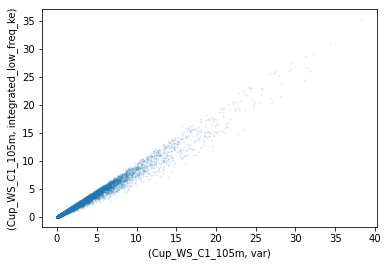

In [132]:
met.plot.scatter(('Cup_WS_C1_105m', 'var'), ('Cup_WS_C1_105m', 'integrated_low_freq_ke'), alpha=0.1, s=1)

From the plot above, linear regression is an obvious choice of baseline model.